In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from MPCVelControl_D3_2 import MPCVelControl

from MPCControl_xvel_D3_2 import MPCControl_xvel
from MPCControl_xvel_D3_2 import MPCControl_xvel_tuned_default
from MPCControl_xvel_D3_2 import MPCControl_xvel_tuned_final

from MPCControl_yvel_D3_2 import MPCControl_yvel
from MPCControl_yvel_D3_2 import MPCControl_yvel_tuned_default
from MPCControl_yvel_D3_2 import MPCControl_yvel_tuned_final

from MPCControl_zvel_D3_2 import MPCControl_zvel
from MPCControl_zvel_D3_2 import MPCControl_zvel_tuned_default
from MPCControl_zvel_D3_2 import MPCControl_zvel_tuned_final

from MPCControl_roll_D3_2 import MPCControl_roll
from MPCControl_roll_D3_2 import MPCControl_roll_tuned_default
from MPCControl_roll_D3_2 import MPCControl_roll_tuned_final


from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 0.05
sim_time = 7
H = 5.0
N = int(H / Ts)

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
mpc = MPCVelControl().new_controller(rocket, Ts, H)

x0 = xs.copy()          # start at trim
x_target = xs.copy()    # reference is also around trim

x_target[6] = 3.0 # Target x-velocity of 3 m/s
x_target[7] = 3.0 # Target y-velocity of 0 m/s
x_target[8] = 3.0 # Target z-velocity of 0 m/s
x_target[5] = np.deg2rad(35) # Target roll rate of

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 i

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(12, 140))

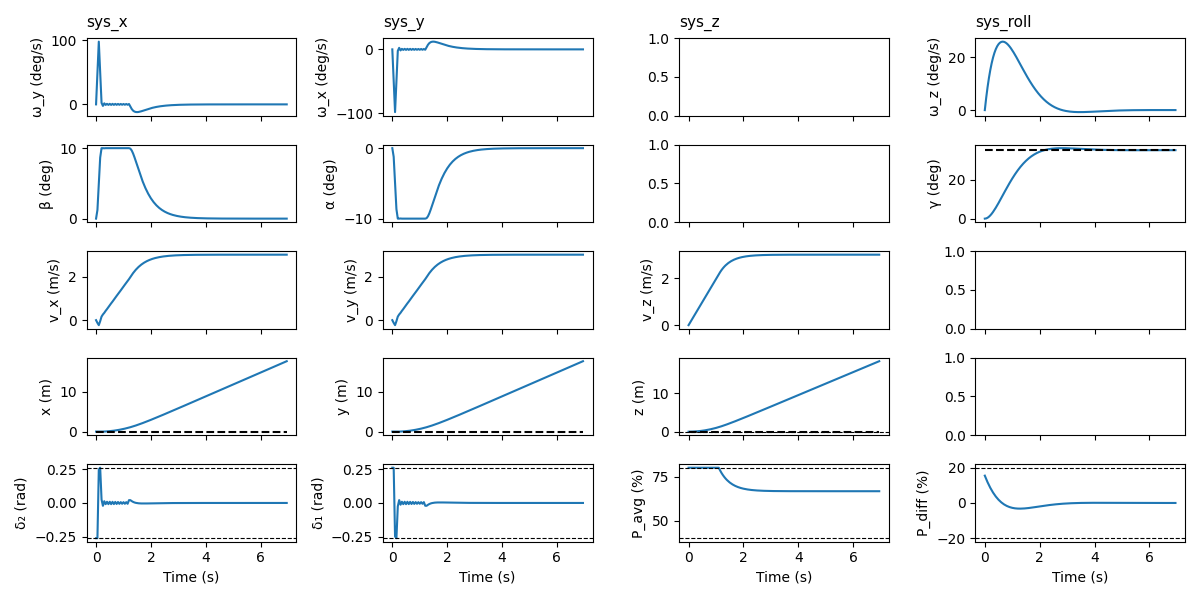

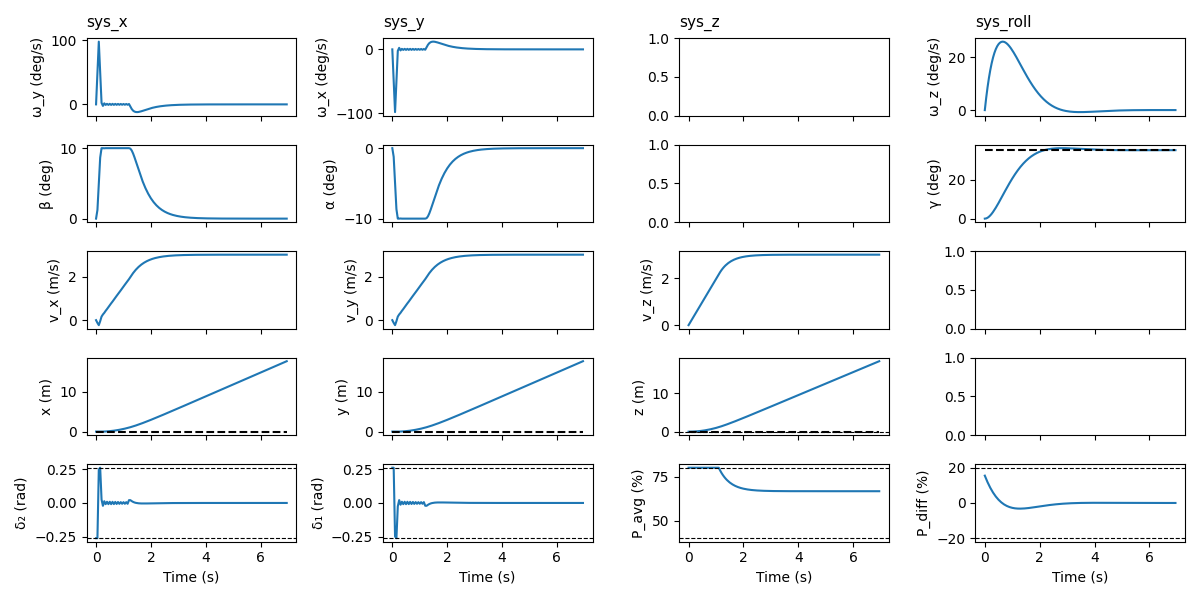

In [4]:
from src.vel_rocket_vis import plot_static_states_inputs
import matplotlib.pyplot as plt

T = t_cl[:-1]
X = x_cl[:, :-1]
U = u_cl
ref = ref[:,:-1]

plot_static_states_inputs(T, X, U, ref)

plt.savefig("closedloop_states_inputs.pdf", bbox_inches="tight")
plt.show()


In [5]:
from plot_style import set_mpc_style
set_mpc_style()

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Maximum invariant set found after 14 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet co

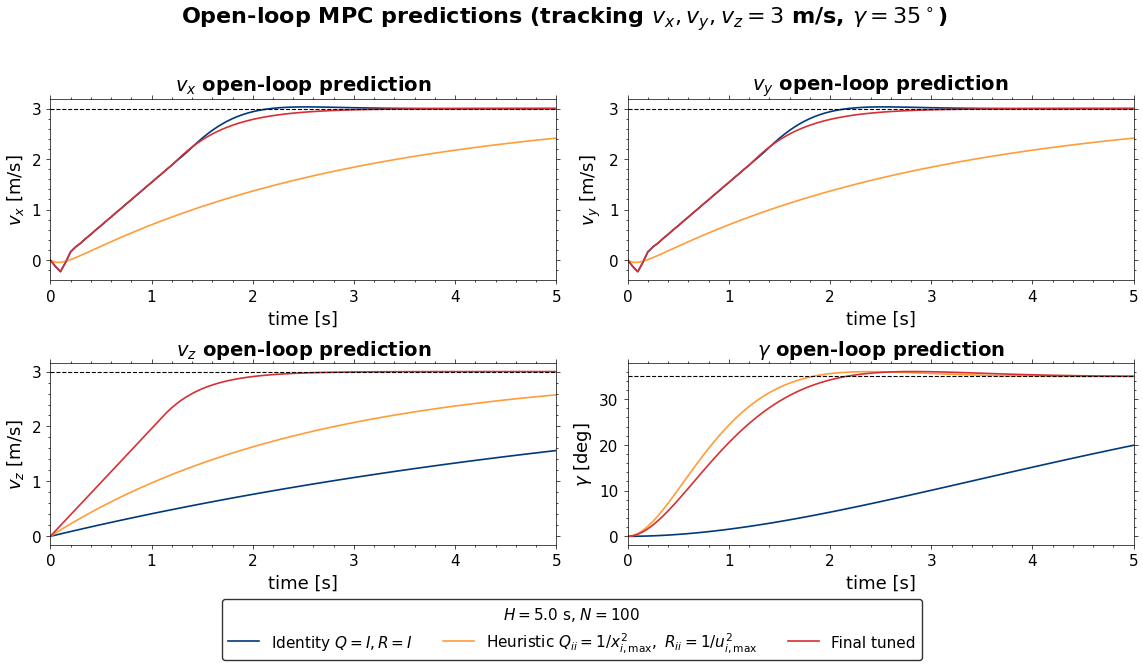

In [6]:
#Open loop plots

import numpy as np
import matplotlib.pyplot as plt

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)   
x0 = xs.copy()  # start at trim (≈ 0 deviation)

# full-state tracking reference: vx=vy=vz=3, gamma=35deg (everything else at trim)
x_ref = xs.copy()
x_ref[6] = 3.0
x_ref[7] = 3.0
x_ref[8] = 3.0
x_ref[5] = np.deg2rad(35.0)

# ---------- helper ----------
def run_open_loop(mpc_cls, A, B, xs, us, Ts, H,
                  x0_full, xref_full,
                  tracked_full_idx, y_transform=lambda y: y):

    mpc = mpc_cls(A, B, xs, us, Ts, H)
    x0_sub   = x0_full[mpc.x_ids]
    xref_sub = xref_full[mpc.x_ids]

    # u_target slice is optional; safe default is the trim for that subsystem
    uref_sub = mpc.us

    # IMPORTANT: pass reduced vector refs (not scalars)
    _, x_ol, _ = mpc.get_u(x0_sub, x_target=xref_sub, u_target=uref_sub)

    t = np.arange(x_ol.shape[1]) * Ts
    local_idx = list(mpc.x_ids).index(tracked_full_idx)
    y = y_transform(x_ol[local_idx, :])
    return t, y


# ---------- controller sets ----------
ctrl_sets = {
    "Identity $Q=I,R=I$": (
        MPCControl_xvel, MPCControl_yvel,
        MPCControl_zvel, MPCControl_roll
    ),
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": (
        MPCControl_xvel_tuned_default,
        MPCControl_yvel_tuned_default,
        MPCControl_zvel_tuned_default,
        MPCControl_roll_tuned_default
    ),
    "Final tuned": (
        MPCControl_xvel_tuned_final,
        MPCControl_yvel_tuned_final,
        MPCControl_zvel_tuned_final,
        MPCControl_roll_tuned_final
    ),
}

# ---------- figure ----------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))
fig.suptitle("Open-loop MPC predictions (tracking $v_x,v_y,v_z=3$ m/s, $\\gamma=35^\\circ$)",
             fontsize=16, fontweight="bold", y=0.98)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11


def format_ax(ax, title, ylabel, ref_line=None):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel("time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    if ref_line is not None:
        ax.axhline(ref_line, linestyle="--", color="k", linewidth=0.8)
    ax.set_xlim(0, H)
    ax.tick_params(labelsize=TICK_FONTSIZE)

# ---------- vx ----------
ax = axs[0, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cx, A, B, xs, us, Ts, H, x0, x_ref, tracked_full_idx=6)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_x$ open-loop prediction", r"$v_x$ [m/s]", ref_line=3.0)

# ---------- vy ----------
ax = axs[0, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cy, A, B, xs, us, Ts, H, x0, x_ref, tracked_full_idx=7)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_y$ open-loop prediction", r"$v_y$ [m/s]", ref_line=3.0)

# ---------- vz ----------
ax = axs[1, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cz, A, B, xs, us, Ts, H, x0, x_ref, tracked_full_idx=8)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_z$ open-loop prediction", r"$v_z$ [m/s]", ref_line=3.0)

# ---------- roll gamma ----------
ax = axs[1, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cr, A, B, xs, us, Ts, H, x0, x_ref,
                         tracked_full_idx=5, y_transform=np.rad2deg)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$\gamma$ open-loop prediction", r"$\gamma$ [deg]", ref_line=35.0)

# ---------- legend + save ----------
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
           title=fr"$H={H}$ s, $N={int(H/Ts)}$", title_fontsize=LEGEND_FONTSIZE)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
fig.savefig("openloop_tracking_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()



Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 

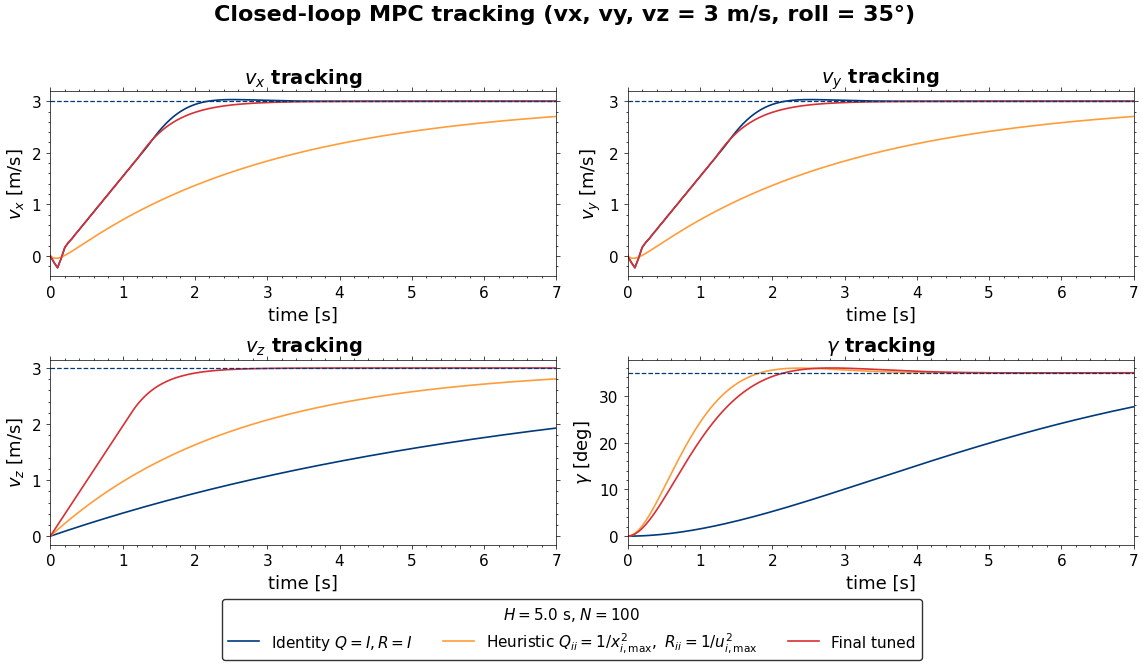

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Setup
# -----------------------------
Ts = 0.05
sim_time = 7
H = 5.0

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()

# Start at trim ("origin")
x0 = xs.copy()

# Constant tracking reference (3 m/s for vx,vy,vz and 35 deg roll)
x_ref = xs.copy()
x_ref[6] = 3.0
x_ref[7] = 3.0
x_ref[8] = 3.0
x_ref[5] = np.deg2rad(35.0)

# -----------------------------
# 1) Make 3 MPCVelControl variants (Identity / Heuristic / Final)
# -----------------------------
from MPCVelControl_D3_2 import MPCVelControl  # your D3.2 file

class MPCVelControl_I(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TD(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_default(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TF(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_final(A, B, self.xs, self.us, Ts, H)
        return self

ctrl_sets_cl = {
    "Identity $Q=I,R=I$": MPCVelControl_I,
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": MPCVelControl_TD,
    "Final tuned": MPCVelControl_TF,
}

# -----------------------------
# 2) Helper: run closed-loop tracking
# -----------------------------
def run_closed_loop_tracking(mpc_full_cls, rocket, Ts, H, sim_time, x0_full, x_ref_full, method="linear"):
    mpc = mpc_full_cls().new_controller(rocket, Ts, H)
    t_cl, x_cl, u_cl, *_ = rocket.simulate_control(
        mpc, sim_time, H, x0_full, method=method, x_target=x_ref_full
    )
    return t_cl, x_cl, u_cl

# -----------------------------
# 3) Plot (2x2)
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))
fig.suptitle("Closed-loop MPC tracking (vx, vy, vz = 3 m/s, roll = 35°)", fontsize=16, fontweight="bold", y=0.98)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11


def format_ax(ax, title, ylabel, ref=None):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel("time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    if ref is not None:
        ax.axhline(ref, linestyle="--", linewidth=0.9)
    ax.set_xlim(0, sim_time)
    #ax.grid(True)
    ax.tick_params(labelsize=TICK_FONTSIZE)

# --- vx ---
ax = axs[0, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[6, :], label=lbl)
format_ax(ax, r"$v_x$ tracking", r"$v_x$ [m/s]", ref=3.0)

# --- vy ---
ax = axs[0, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[7, :], label=lbl)
format_ax(ax, r"$v_y$ tracking", r"$v_y$ [m/s]", ref=3.0)

# --- vz ---
ax = axs[1, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[8, :], label=lbl)
format_ax(ax, r"$v_z$ tracking", r"$v_z$ [m/s]", ref=3.0)

# --- roll gamma ---
ax = axs[1, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, np.rad2deg(x[5, :]), label=lbl)
format_ax(ax, r"$\gamma$ tracking", r"$\gamma$ [deg]", ref=35.0)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
           title=fr"$H={H}$ s, $N={int(H/Ts)}$", title_fontsize=LEGEND_FONTSIZE)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
fig.savefig("closedloop_tracking_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()
